In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mne
import os
import sys
from mne.datasets import eegbci
import glob
from IPython.display import clear_output
import numpy as np
import torch
from torch import nn
import torch.optim as optim

from mne.datasets import eegbci
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from scipy import signal

import torch
import torch.cuda as cuda
import torch.nn as nn
from torch.autograd import Variable
import math
import wandb


In [2]:
torch.cuda.is_available()

True

In [3]:
from common import EEG_fif
from common import create_dataloader

In [4]:
# home directory + datasets folder
#path = '/content/drive/MyDrive/MNE-eegbci-data/files/eegmmidb/'
path = ''
base_url = 'https://physionet.org/files/eegmmidb/'
#runs = [4, 6, 8, 10, 12,14]
#runs = [3,5,7,9,11,13]
#runs = [3,4,5,6,7,8,9,10,11,12,13,14]

n_type = "ALL"
#n_type = "MI"
#n_type = "EX"
#runs = [3,5,7,9]
#runs = [4,6,8,10]
runs = [3,5,7,9,4,6,8,10]

#subjects = [20,31,48,50,54,55,59,62]
subjects = [9]
print(path)
eeg = EEG_fif(path, base_url, subjects, runs)
raw=eeg.data_to_raw()

print("Raw done")
# apply filter
#freq = (1., 45.)

#raw=eeg.raw_ica(n_components=8,max_iter=1000)
raw=raw.notch_filter([50,75,100])

#raw=raw.notch_filter([13,14,15,16,17])
raw=raw.filter( 8,14, method='fir', verbose=20)
#raw=raw.filter( 8,27, method='fir', verbose=20)
#for i in range(5):
#    raw=raw.notch_filter([13+i])
#    print(13+i)
print("Filter done")

/home/nutapolt/eeg_mi/common.py:627: RuntimeWarning: This filename (S009/S009R03.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif( path_file , preload=True, verbose='WARNING' )


Raw done
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)



/home/nutapolt/eeg_mi/common.py:627: RuntimeWarning: This filename (S009/S009R05.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif( path_file , preload=True, verbose='WARNING' )
/home/nutapolt/eeg_mi/common.py:627: RuntimeWarning: This filename (S009/S009R07.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif( path_file , preload=True, verbose='WARNING' )
/home/nutapolt/eeg_mi/common.py:627: RuntimeWarning: This filename (S009/S009R09.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fi

Filtering raw data in 8 contiguous segments
Setting up band-pass filter from 8 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 15.75 Hz)
- Filter length: 413 samples (1.652 sec)

Filter done


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


In [5]:
#raw = raw.drop_channels(['Fp1', 'Fp2', 'P7', 'P8', 'O1', 'O2'])
raw=raw.pick_channels(['C3', 'C4', 'STIM MARKERS'])
# raw = raw.drop_channels(['Fz',
#  'Cz',
#  'Pz',
#  'PO7',
#  'Oz',
#  'PO8',
#  'F5',
#  'F7',
#  'F3',
#  'F1',
#  'F2',
#  'F4',
#  'F6',
#  'F8'])
raw.ch_names

['C3', 'C4', 'STIM MARKERS']

Effective window size : 8.192 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


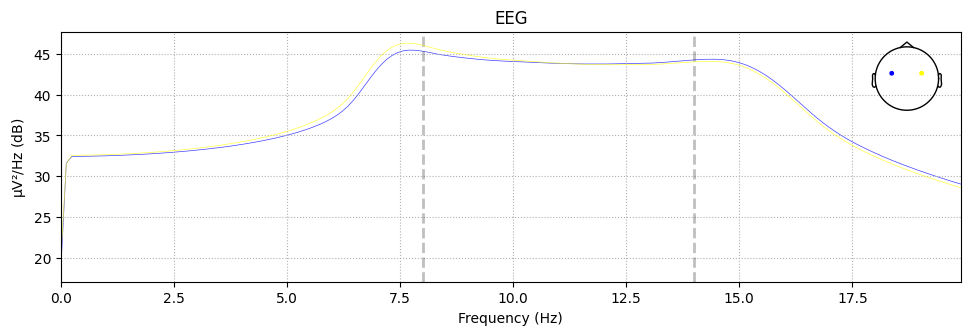

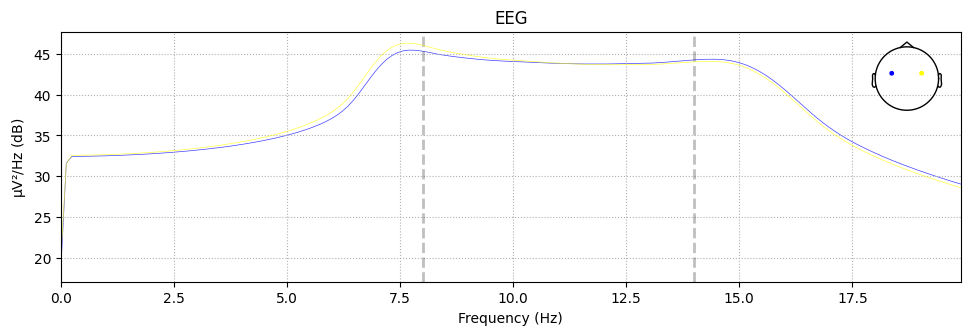

In [6]:
eeg.raw.plot_psd(fmax=20)

In [7]:
#epochs=eeg.epochs_visu(raw,tmin=0,tmax=6,baseline=(0,3))
epochs=eeg.epochs_visu(raw,tmin=0,tmax=7,baseline=(0,2))

480 events found
Event IDs: [1 2 4]
Not setting metadata
160 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 160 events and 1751 original time points ...
8 bad epochs dropped


/home/nutapolt/eeg_mi/common.py:657: RuntimeWarning: No matching events found for 3 (event id 3)
  epochs = mne.Epochs(


In [8]:
epochs

Number of events,152
Events,3: 0Left: 72Right: 80
Time range,0.000 – 7.000 sec
Baseline,0.000 – 2.000 sec


In [9]:
#X = X[:, :,np.newaxis,:]
X, y = eeg.get_X_y(epochs)
print(X.shape)
X=X[:,:,int(0.25*250):1500]
#X = X[:, np.newaxis,:,:]
print(X.shape)
y=y-1
y

(152, 2, 1751)
(152, 2, 1438)


array([0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0])

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,stratify=y)

print('train size',X_train.shape, y_train.shape)
print('Test size',X_test.shape, y_test.shape)

train size (106, 2, 1438) (106,)
Test size (46, 2, 1438) (46,)


In [11]:
y_test

array([0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1,
       0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       0, 1])

In [12]:



batch_size = X_train.shape[2]

train_loader = create_dataloader(X_train, y_train, batch_size=batch_size)
test_loader = create_dataloader(X_test, y_test, batch_size=batch_size)

num_step =math.ceil(len(train_loader.dataset) / batch_size)



in_channels  = X.shape[1] #C3, C4
out_channels = 64  #five is logical because we have freq= 8, 9, 10, 11, 12 that we want to capture
out_size     = 2  #left or right
kernel_size  = 5




In [13]:

# Convolutional neural network (two convolutional layers)
class ConvNet(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, out_size):
        super().__init__()
        #using sequential helps bind multiple operations together
        self.layer1 = nn.Sequential(
            #padding = (kernel_size - 1) / 2 = 2
            nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=2),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv1d(out_channels, out_channels*2, kernel_size=kernel_size, stride=1, padding=2),
            nn.BatchNorm1d(out_channels*2),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv1d(out_channels*2, out_channels, kernel_size=kernel_size, stride=1, padding=2),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
        )
        
        
        self.fc = nn.Linear(linear_shape  , out_size)
        #self.fc = nn.Linear(80064 , 2)
        
        self.drop_out = nn.Dropout(0.5)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.drop_out(out)
        out = self.layer2(out)
        out = self.drop_out(out)
        out = self.layer3(out)
        #out = self.drop_out(out)
        #out = self.layer4(out)
        #out = self.drop_out(out)

        out = out.reshape(out.size(0), -1)   #can also use .view()
        out = self.fc(out)
        return out

In [14]:
x_train = torch.FloatTensor(X_train)

In [15]:
fake_eeg_data = torch.randn_like(x_train) #(batch_size, channel, length)

In [16]:
layer1 = nn.Sequential(
                #padding = (kernel_size - 1) / 2 = 2
                nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=2),
                nn.BatchNorm1d(out_channels),
                nn.ReLU()
                # nn.MaxPool2d(kernel_size=2, stride=2)
            )
layer2 = nn.Sequential(
                nn.Conv1d(out_channels, out_channels*2, kernel_size=kernel_size, stride=1, padding=2),
                nn.BatchNorm1d(out_channels*2),
                nn.ReLU()
                # nn.MaxPool2d(kernel_size=2, stride=2)
            )
layer3 = nn.Sequential(
                nn.Conv1d(out_channels*2, out_channels, kernel_size=kernel_size, stride=1, padding=2),
                nn.BatchNorm1d(out_channels),
                nn.ReLU()
            )


out = layer1(fake_eeg_data)
out = layer2(out)
out = layer3(out)
out = out.reshape(out.size(0), -1)
linear_shape = out.shape[1]
fc = nn.Linear(linear_shape, out_size)
out = fc(out)

In [17]:
torch.cuda.get_device_name(0)

'NVIDIA RTX A6000'

In [18]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: nutapol-1997 (eeg_mi). Use `wandb login --relogin` to force relogin


True

In [19]:
import os
os.environ['http_proxy'] = "http://192.41.170.23:3128" 
os.environ['https_proxy'] = "http://192.41.170.23:3128" 

In [20]:

wand = wandb.init(
        
      # Set the project where this run will be logged
      project="Motor-Imagery", 
      # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
      name="CNN_2class_S{0}_{1}_New".format(subjects[:],n_type), 
      # Track hyperparameters and run metadata
      config={
      "learning_rate": 0.0000001,
      "architecture": "CNN",
      "dataset": "S{}".format(subjects[0]),
      "epochs": 100000,
      "weightname":"CNN_2class_S{0}_{1}_New".format(subjects[:],n_type),
      "num_step_per_epoch" : num_step, 
        
      }
    )



In [21]:
config = wand.config
print(config.num_step_per_epoch)

1


In [22]:
from common import train

In [23]:
net = ConvNet(in_channels, out_channels, kernel_size, out_size).cuda(0)
optimizer = optim.Adam(net.parameters(), lr=config.learning_rate)
criterion = nn.CrossEntropyLoss()


train_loss,valid_loss,train_accuracy,valid_accuracy =train(
    model = net,
    gpu_num = 0,
    train_loader = train_loader,
    test_loader = test_loader,
    optimizer = optimizer  ,
    criterion = criterion ,
    wand = wand
         )


wandb.alert(
            title='Finish',
            text=f'Finishing training',
        )

Epoch 1/100000, Tr Loss: 0.7176, Tr Acc: 50.9434, Val Loss: 0.6924, Val Acc: 52.1739
Epoch 101/100000, Tr Loss: 0.7533, Tr Acc: 50.9434, Val Loss: 0.7066, Val Acc: 45.6522
Epoch 201/100000, Tr Loss: 0.7136, Tr Acc: 51.8868, Val Loss: 0.6904, Val Acc: 56.5217
Epoch 301/100000, Tr Loss: 0.7238, Tr Acc: 51.8868, Val Loss: 0.6904, Val Acc: 56.5217
Epoch 401/100000, Tr Loss: 0.7001, Tr Acc: 57.5472, Val Loss: 0.6926, Val Acc: 56.5217
Epoch 501/100000, Tr Loss: 0.6999, Tr Acc: 54.7170, Val Loss: 0.6938, Val Acc: 52.1739
Epoch 601/100000, Tr Loss: 0.6716, Tr Acc: 56.6038, Val Loss: 0.6920, Val Acc: 58.6957
Epoch 701/100000, Tr Loss: 0.7038, Tr Acc: 51.8868, Val Loss: 0.6907, Val Acc: 56.5217
Epoch 801/100000, Tr Loss: 0.6518, Tr Acc: 60.3774, Val Loss: 0.6931, Val Acc: 56.5217
Epoch 901/100000, Tr Loss: 0.6578, Tr Acc: 64.1509, Val Loss: 0.6920, Val Acc: 60.8696
Epoch 1001/100000, Tr Loss: 0.6563, Tr Acc: 61.3208, Val Loss: 0.6925, Val Acc: 56.5217
Epoch 1101/100000, Tr Loss: 0.6436, Tr Acc: 

KeyboardInterrupt: 